In [1]:
import os,sys
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import glob

In [2]:
dicti = {'A':0,'N':0,'C':0,'Q':0,'G':0,'I':0,'L':0,'M':0,'F':0,'P':0,'S':0,'T':0,'W':0,'Y':0,'V':0,'H':0,'K':1,'R':1,'D':-1,'E':-1}


In [3]:
A8 = pd.read_csv('A8out100Msteps.traj',delim_whitespace=True)
A13 = pd.read_csv('A13out100Msteps.traj',delim_whitespace=True)
A18 = pd.read_csv('A18out100Msteps.traj',delim_whitespace=True)

In [4]:
A8_fep = pd.read_pickle('../../data/EE/A8_RBFE.pkl')
A13_fep = pd.read_pickle('../../data/EE/A13_RBFE.pkl')
A18_fep = pd.read_pickle('../../data/EE/A18_RBFE.pkl')
A8_exp=pd.read_pickle('../../data/Experiment/A8_exp_dg.pkl')
A13_exp=pd.read_pickle('../../data/Experiment/A13_exp_dg.pkl')
A18_exp = pd.read_pickle('../../data/Experiment/A18_exp_dg.pkl')

In [5]:
# Fix Rosetta A8 Df
A8_ros_pub = pd.read_csv('../../data/published_rosetta/norm_final_A8_rosetta.csv')
A8_ros_pub = A8_ros_pub.rename(columns={A8_ros_pub.columns[0]:''}) 
A8_ros_pub.set_index(A8_ros_pub.columns[0],inplace=True)

# Fix Rosetta A13 Df
A13_ros_pub = pd.read_csv('../../data/published_rosetta/norm_final_A13_rosetta.csv')
A13_ros_pub = A13_ros_pub.rename(columns={A13_ros_pub.columns[0]:''}) 
A13_ros_pub.set_index(A13_ros_pub.columns[0],inplace=True)

# Fix Rosetta A18 Df
A18_ros_pub = pd.read_csv('../../data/published_rosetta/norm_final_A18_rosetta.csv')
A18_ros_pub = A18_ros_pub.rename(columns={A18_ros_pub.columns[0]:''}) 
A18_ros_pub.set_index(A18_ros_pub.columns[0],inplace=True)


A8_curr_ros = pd.read_csv('../../data/current_rosetta/A8_current_rosetta.csv')
A13_curr_ros = pd.read_csv('../../data/current_rosetta/A13_current_rosetta.csv')
A18_curr_ros = pd.read_csv('../../data/current_rosetta/A18_current_rosetta.csv')


def make_df(output,temp):
    output = output[output['state']=='ddg']
    index = list(temp.index)
    columns = temp.columns
    array = np.zeros(shape=(len(index),len(columns)))
    temp = pd.DataFrame(array,index=index,columns=columns)
    for index,row in output.iterrows():
        _col = row['position_label']
        _mut = row['mutation'][-1]
        _val = row['total_score']
        temp[_col][_mut]+=_val
    return temp

A8_curr_ros = make_df(A8_curr_ros,A8_ros_pub.copy())
A13_curr_ros = make_df(A13_curr_ros,A13_ros_pub.copy())
A18_curr_ros = make_df(A18_curr_ros,A18_ros_pub.copy())

In [6]:
xA8 = A8[['sequence','energy','k']].drop_duplicates('sequence',keep='first')
xA13 = A13[['sequence','energy','k']].drop_duplicates('sequence',keep='first')
xA18 = A18[['sequence','energy','k']].drop_duplicates('sequence',keep='first')

In [7]:
wildtype_A8 = open('../../data/sequences/A8_sequence.afasta','r').readlines()[0].split()[0]
wildtype_A8 = [f'{j}{270+i}' for i,j in enumerate(wildtype_A8)]
wildtype_A13 = open('../../data/sequences/A13_sequence.afasta','r').readlines()[0].split()[0]
wildtype_A13 = [f'{j}{270+i}' for i,j in enumerate(wildtype_A13)]
wildtype_A18 = open('../../data/sequences/A18_sequence.afasta','r').readlines()[0].split()[0]
wildtype_A18 = [f'{j}{270+i}' for i,j in enumerate(wildtype_A18)]

In [80]:
def make_mut_count_df(wildtype=None,x=None,FEP_df=None):
    residues = ['A', 'N', 'C', 'Q', 'G', 'I', 'L', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', 'H', 'K', 'R', 'D', 'E']
    counts = {i:{res:0 for res in residues}  for i in wildtype}
    for row in x.values:
        seq,energy,k = row[0], row[1],row[2]
        for i,res in enumerate(seq):
            if k==0:
                key = list(counts.keys())[i]
                counts[key][res]+=1
    #final_counts = {key1:{key2:((val2)/counts[key1][key1[0]]) for key2,val2 in val1.items()} for key1,val1 in counts.items()}
    final_counts = {key1:{key2:((val2)/sum(counts[key1].values())) for key2,val2 in val1.items()} for key1,val1 in counts.items()}
    for key1 in final_counts.keys():
        for key2 in final_counts[key1].keys():
            if key2==key1[0]:
                final_counts[key1][key2]= np.nan
    testdf = pd.DataFrame(final_counts)
    testdf=testdf[list(FEP_df.columns)]
    testdf = testdf.reindex(index = list(FEP_df.index))
    return testdf

In [81]:
A8_counts_df = make_mut_count_df(wildtype=wildtype_A8,x=xA8,FEP_df=A8_fep)
A13_counts_df = make_mut_count_df(wildtype=wildtype_A13,x=xA13,FEP_df=A13_fep)
A18_counts_df = make_mut_count_df(wildtype=wildtype_A18,x=xA18,FEP_df=A18_fep)

In [14]:
from scipy.stats import entropy
from scipy.integrate import quad
beta = 0.593**-1

def shannon_entropy(df):
    # Ensure the DataFrame is not empty
    if df.empty:
        raise ValueError("DataFrame is empty")

    # Calculate probabilities for each column
    probabilities = df.apply(lambda col: np.exp(-beta*col) / np.sum(np.exp(-beta*col)))

    # Calculate Shannon entropy using scipy's entropy function
    entropy_values = [-np.nansum([p*np.log(p) for p in probabilities[col]]) for col in probabilities.columns]

    # Create a new DataFrame with entropy values and column names
    result_df = pd.DataFrame({"Residue": df.columns, "Shannon_Entropy": entropy_values})

    return result_df

def make_ent_df(file,wildtype):
    test=np.loadtxt(file)
    t=pd.DataFrame(test[:,1])
    t.index=([j for j in wildtype if int(j[1:]) in test[:,0].astype(int)])
    return t.T

#test = shannon_entropy(clipped_df)

# Fig. 11 and Supplementary Figure X 

A8_ros 1.4699084010187928 2.9926976843554063
A8_infer_exp 0.6276921813027749 2.6087509422851762
A8_fep 0.04354168115718162 2.85660345462825
A8_stexp 0.040739143635037084 0.9546546145319287


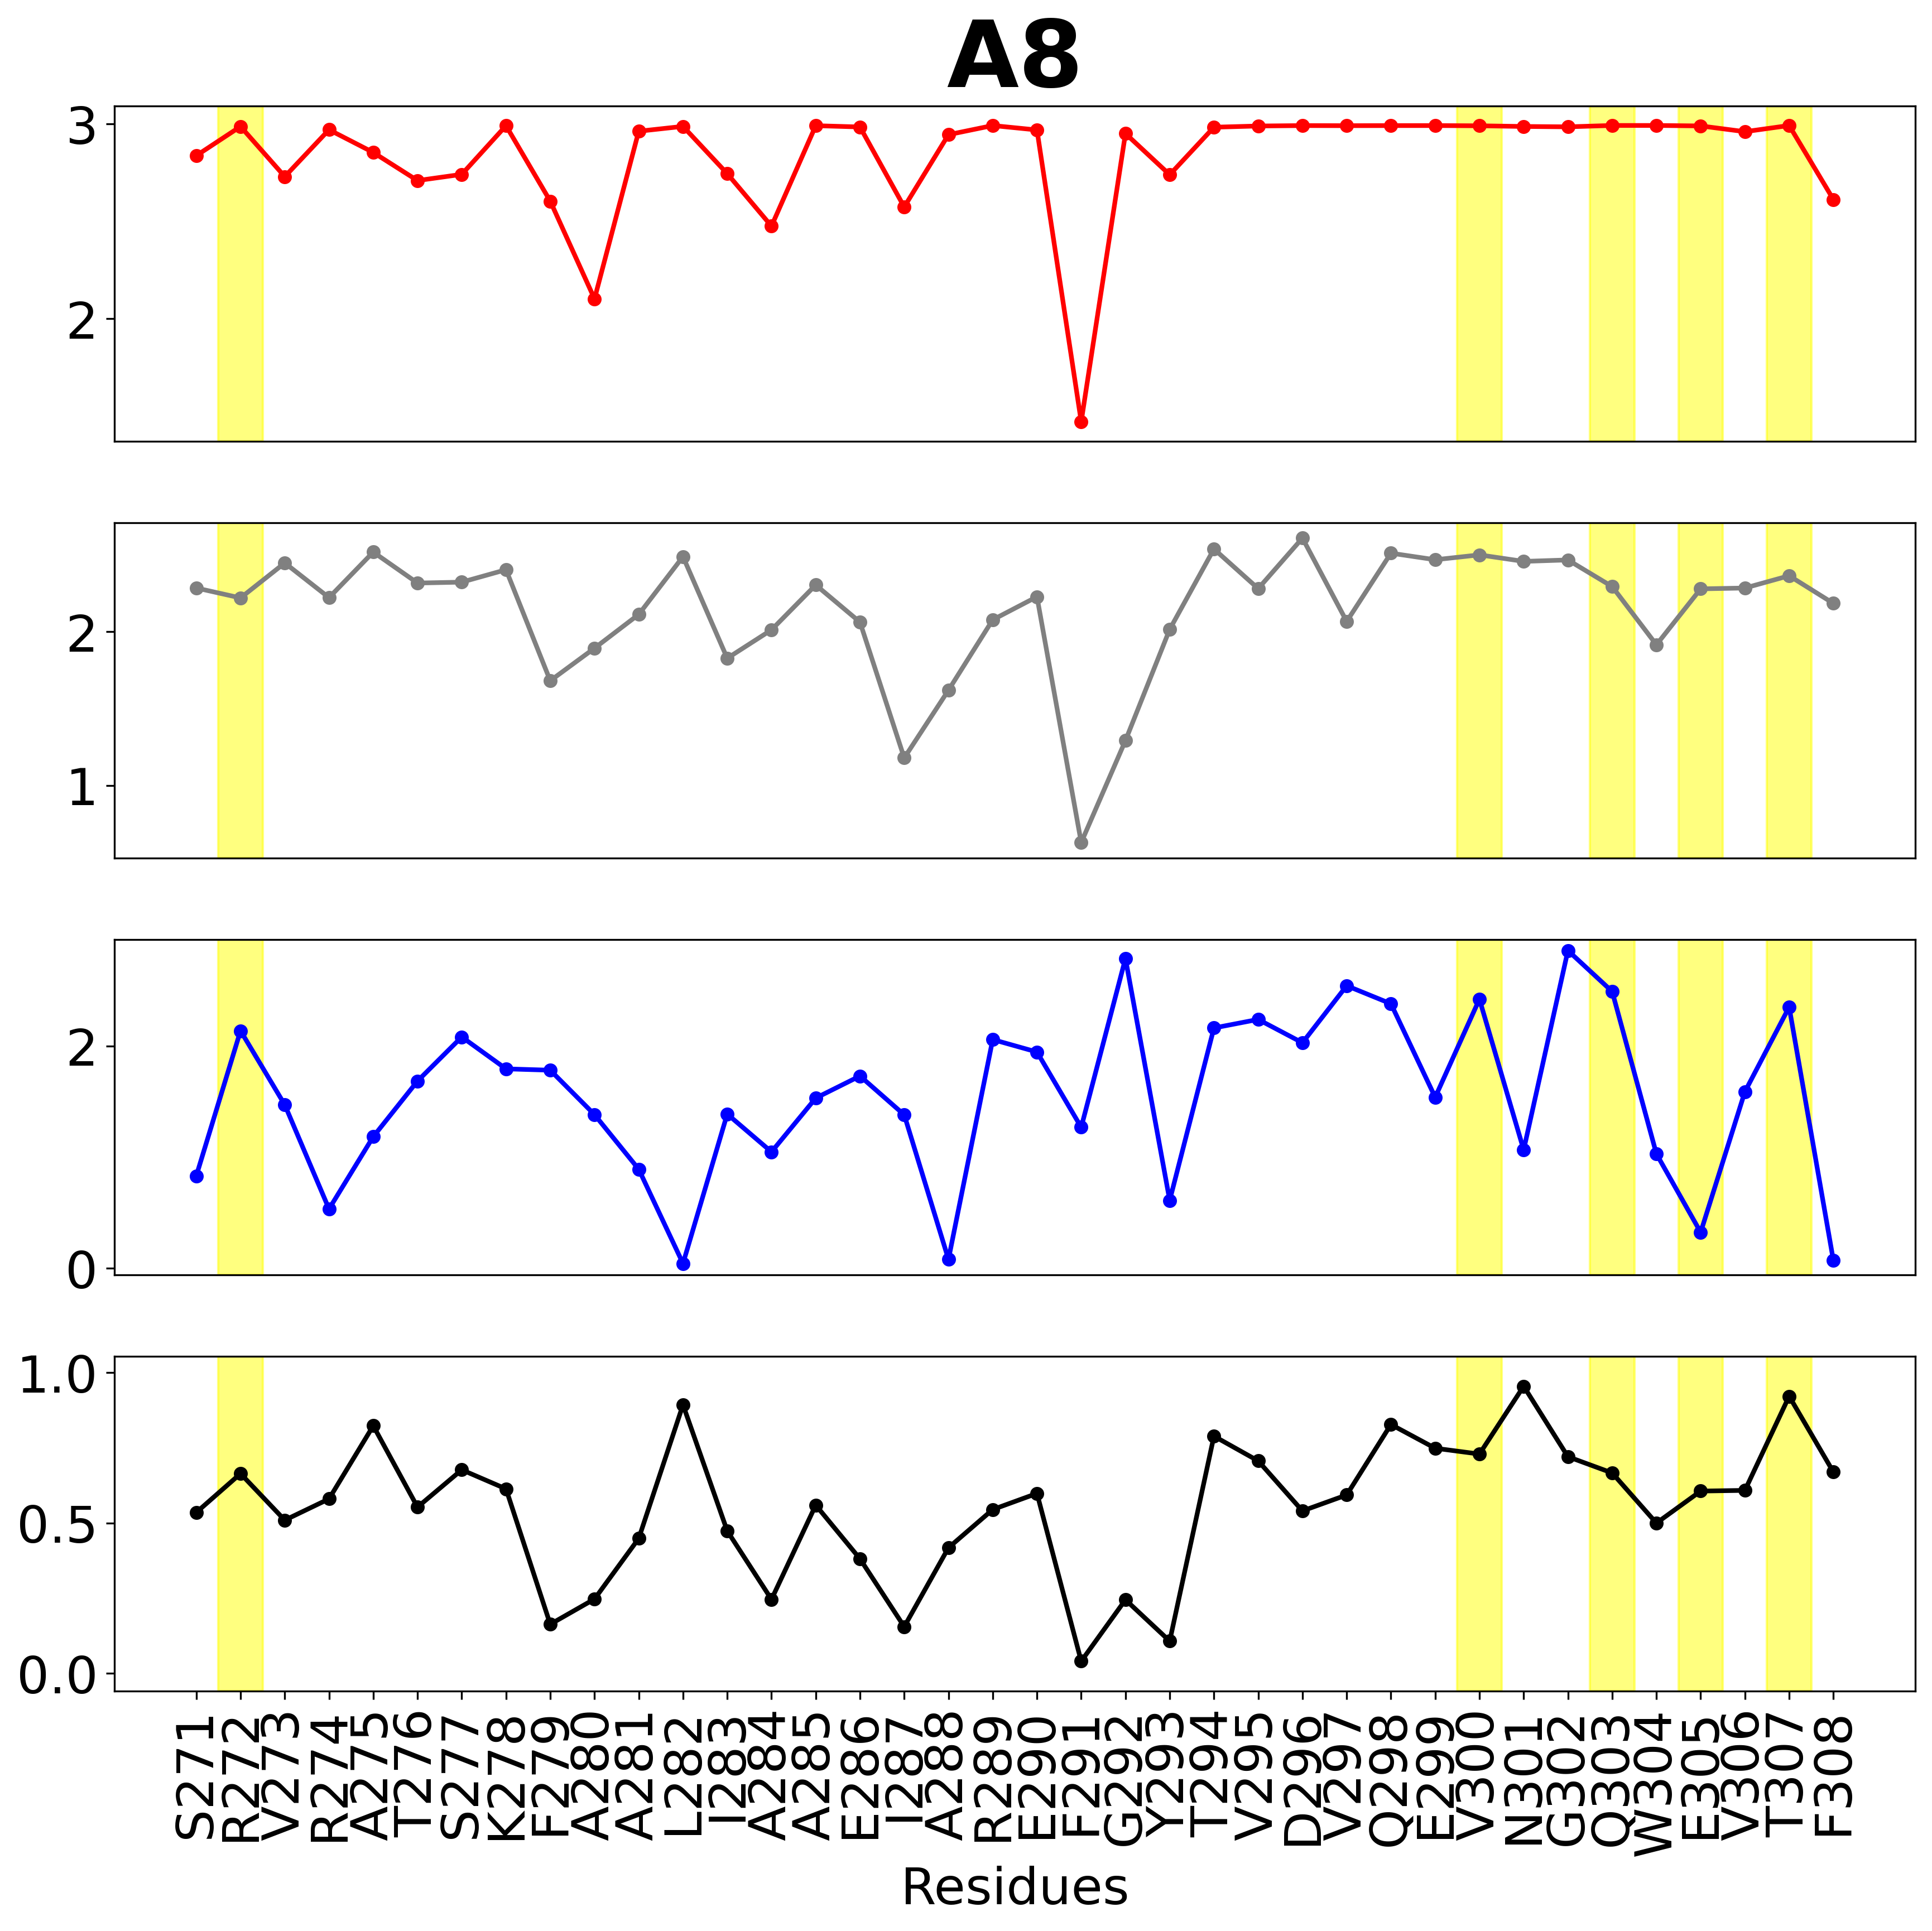

A13_ros 1.4605695327071526 2.995732273553991
A13_infer_exp 0.3934839993854614 2.768349743989056
A13_fep 0.22238529567188217 2.5195789898489824
A13_stexp 0.07144446912741671 1.2308571183015633


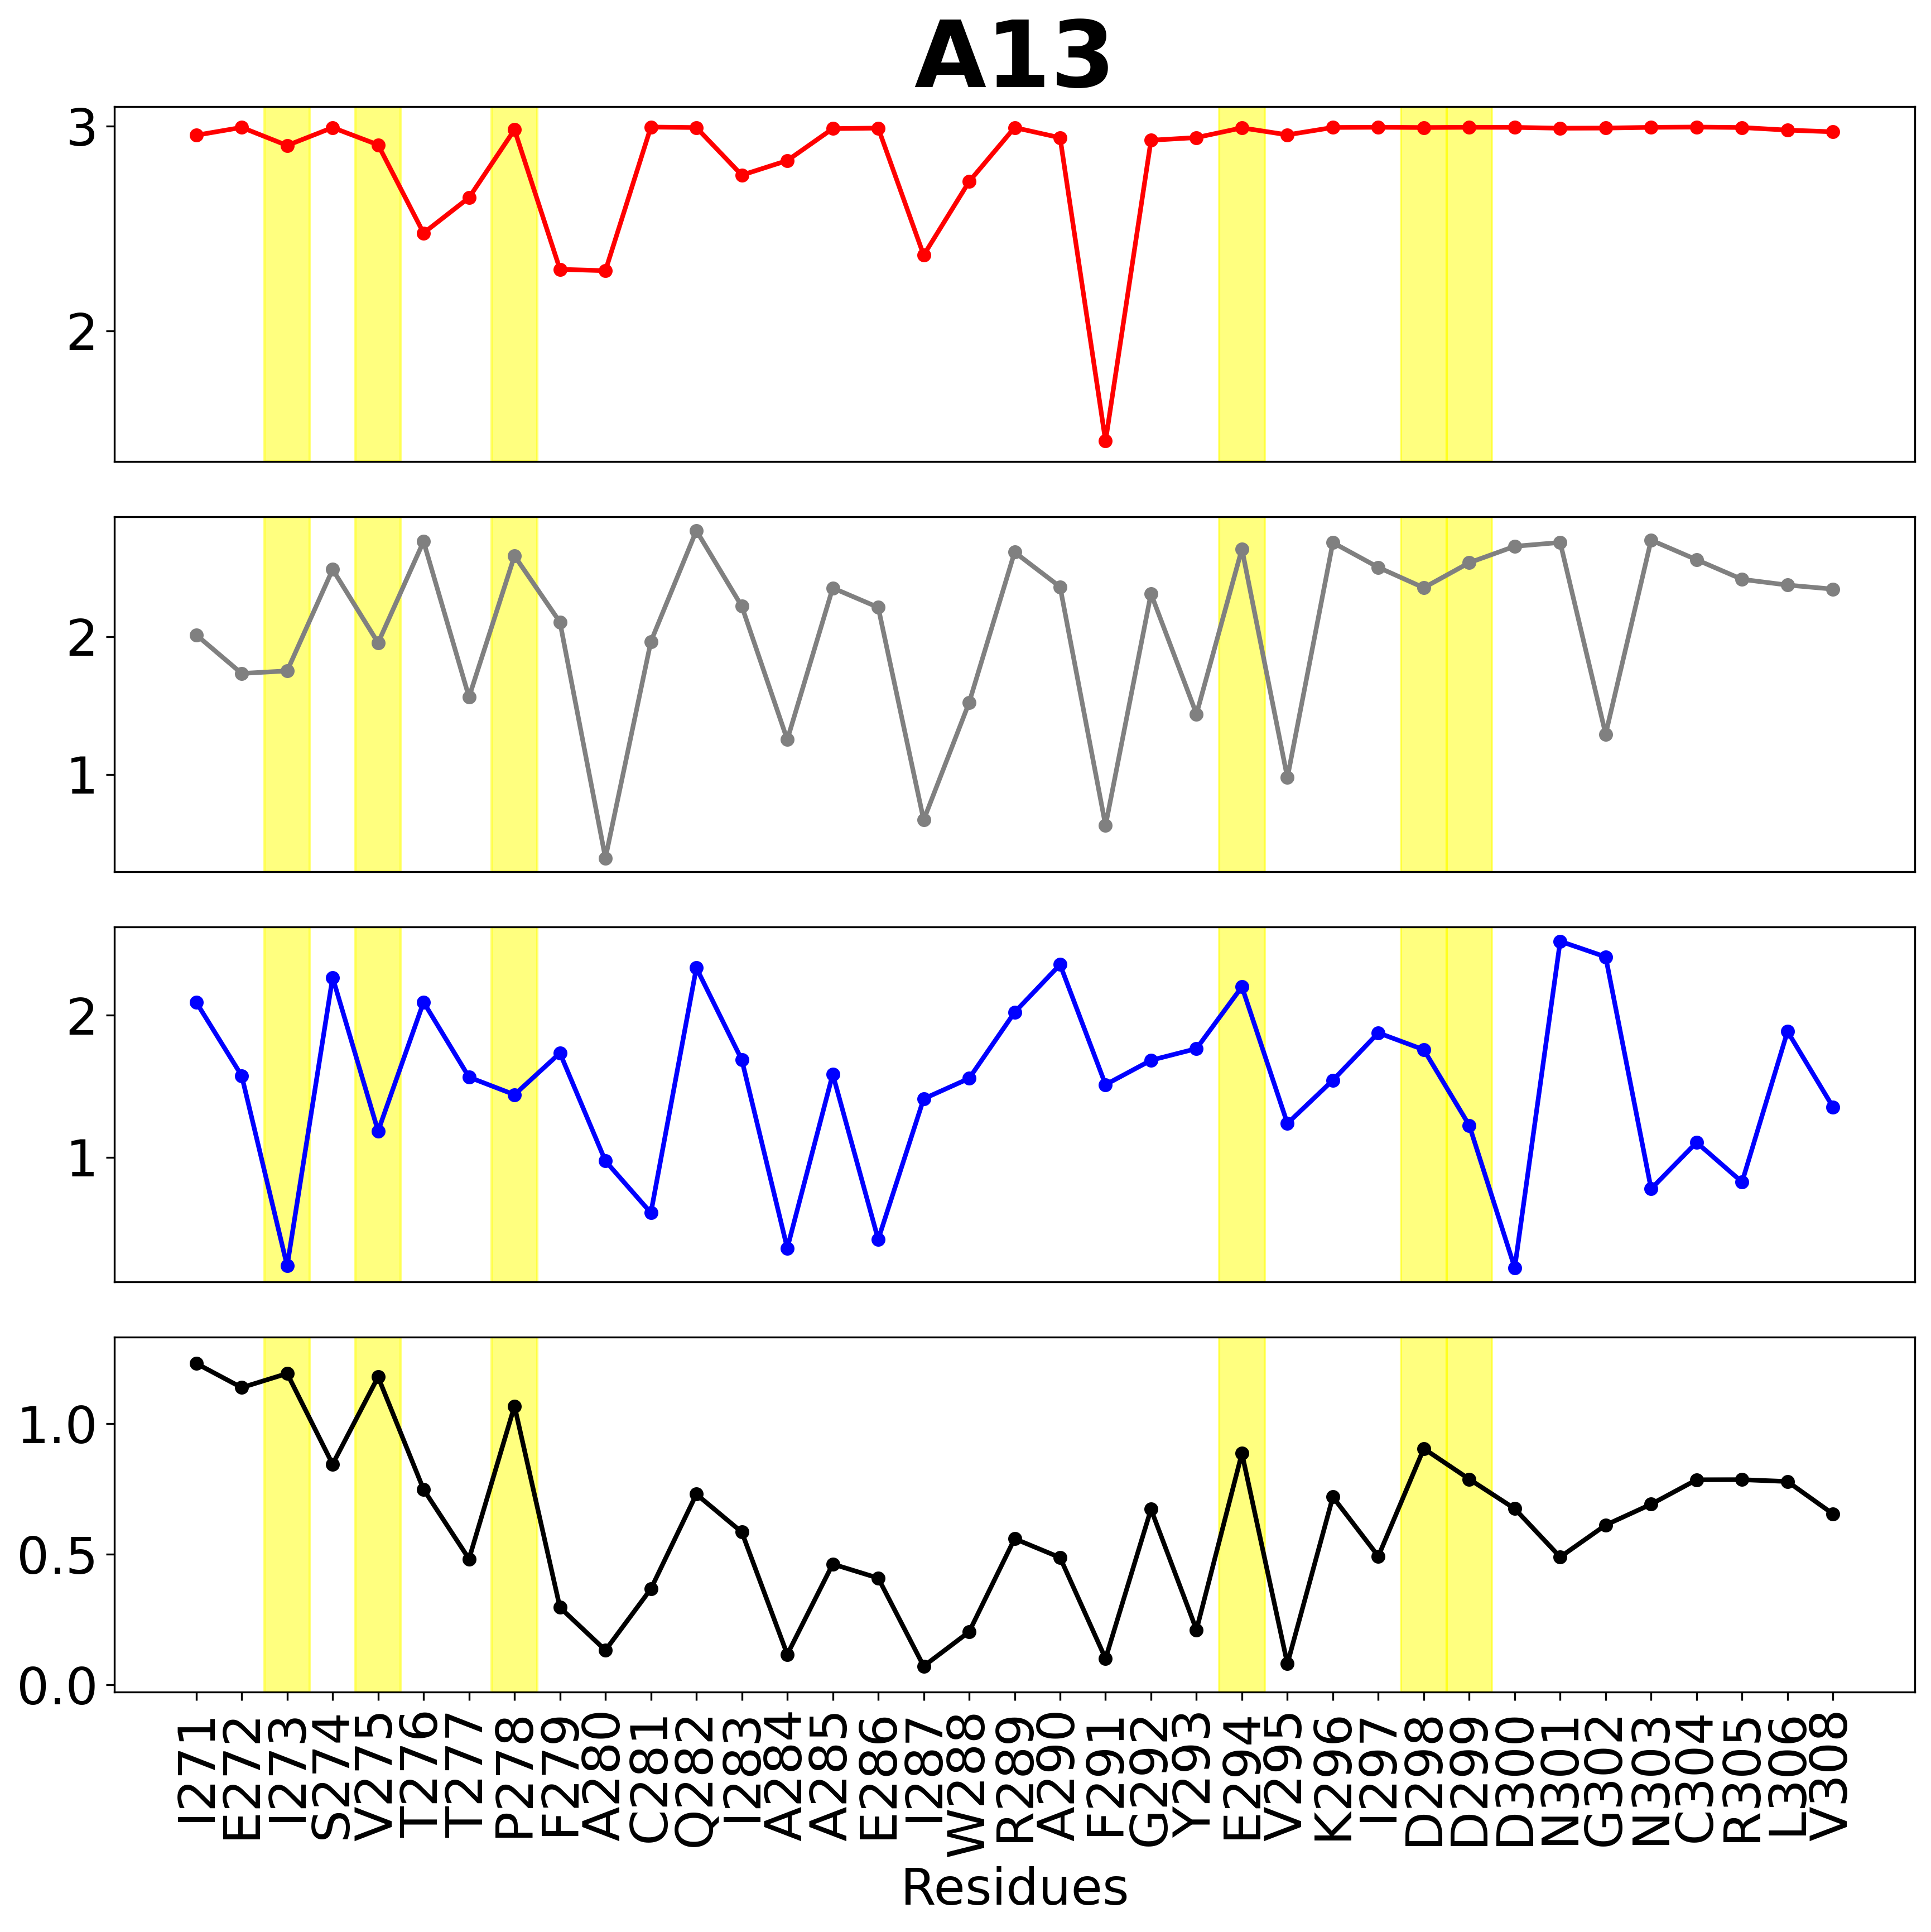

A18_ros 1.3697586825614843 2.9947403396015413
A18_infer_exp 0.4184958902499727 2.7932761223416414
A18_fep 0.032373136327234854 2.5361118817747963
A18_stexp 0.001322756176709747 1.123903227597623


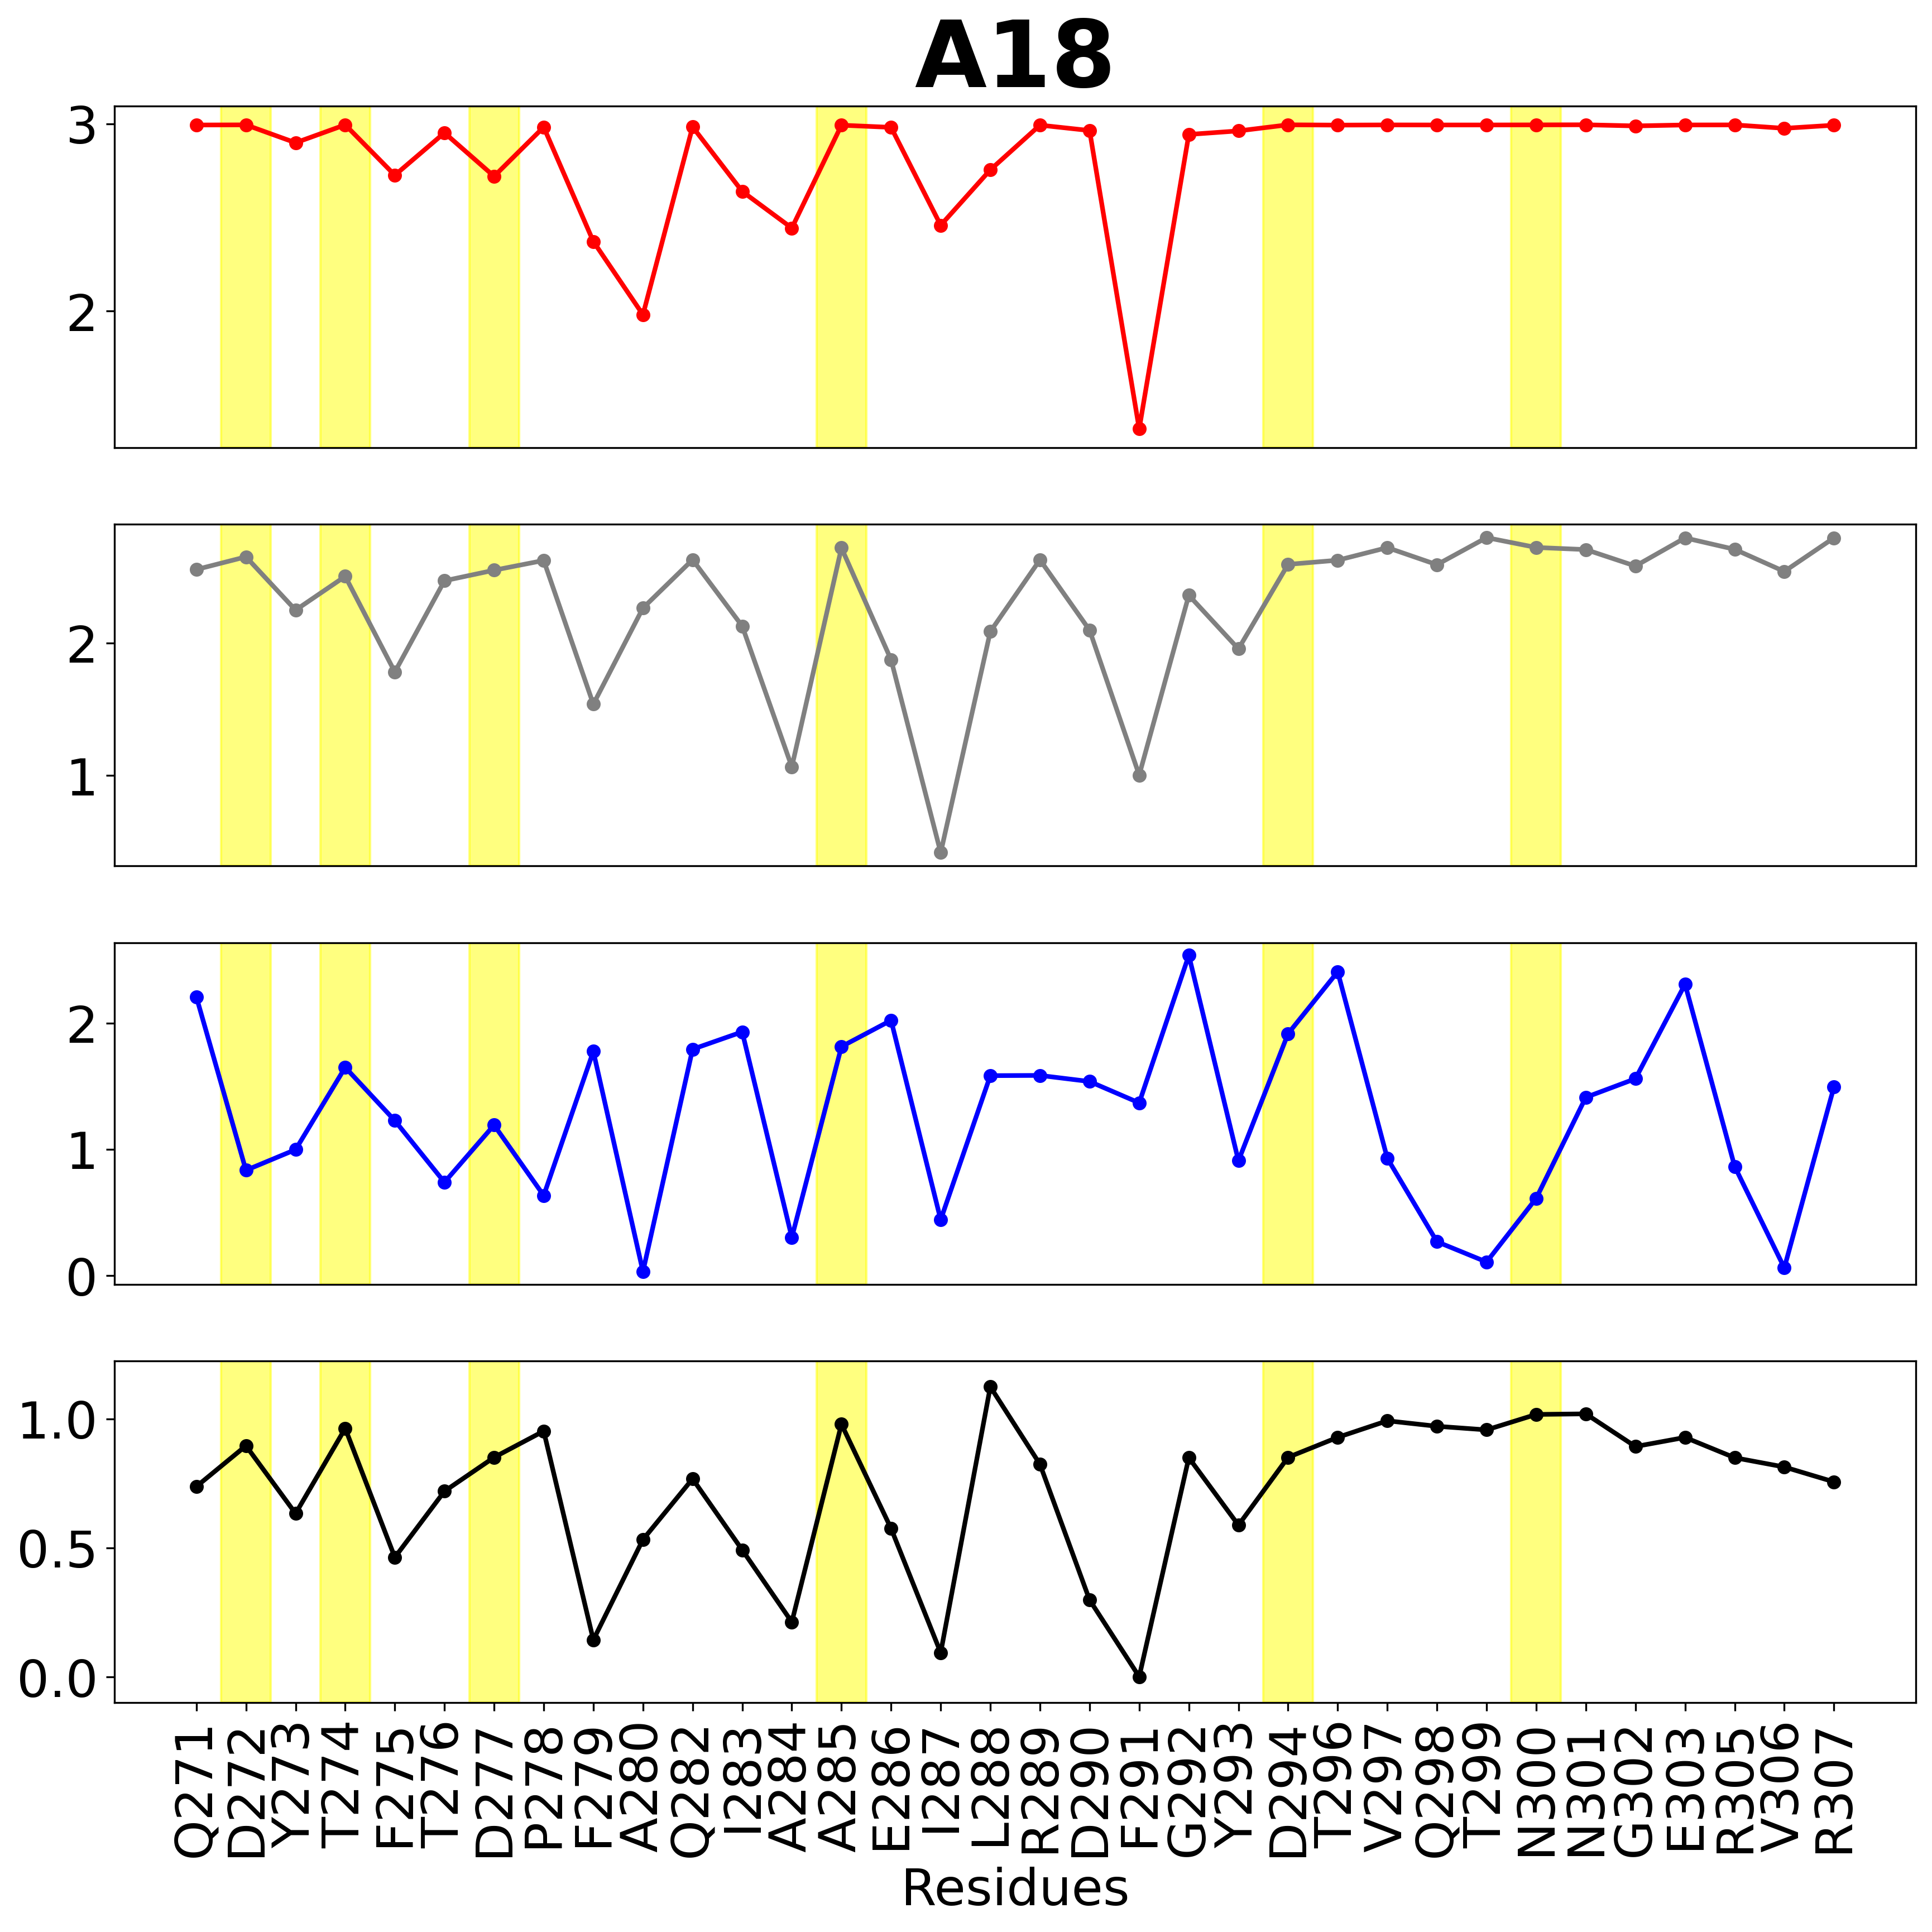

'    \nunique_handles_labels = {}\nfor i in range(4):\n    for j in range(3):\n        h, l = axs[i, j].get_legend_handles_labels()\n        for handle, label in zip(h, l):\n            if label not in unique_handles_labels:\n                unique_handles_labels[label] = handle\n\n# Extract unique handles and labels from the dictionary\nunique_handles = list(unique_handles_labels.values())\nunique_labels = list(unique_handles_labels.keys())\n'

In [85]:
from scipy.stats import linregress
from sklearn.metrics import mutual_info_score
import seaborn as sns

A8_mutation_locations = [1,29,32,34,36]
A13_mutation_locations = [2,4,7,23,27,28]
A18_mutation_locations = [1,3,6,13,22,27]
mutation_locations = [A8_mutation_locations,
                     A13_mutation_locations,
                     A18_mutation_locations]

entropy_dfs = [make_ent_df('A8_mutation_entropy.txt',wildtype_A8),
               make_ent_df('A13_mutation_entropy.txt',wildtype_A13),
               make_ent_df('A18_mutation_entropy.txt',wildtype_A18)]
clipped_dfs = [pd.DataFrame(np.clip(A8_fep.values, -6, 6), columns=A8_fep.columns),
               pd.DataFrame(np.clip(A13_fep.values, -6, 6), columns=A13_fep.columns),
              pd.DataFrame(np.clip(A18_fep.values, -6, 6), columns=A18_fep.columns)]
ros_dfs=[A8_curr_ros[A8_fep.columns],A13_curr_ros[A13_fep.columns],A18_curr_ros[A18_fep.columns]]
exp_dfs=[A8_exp[A8_fep.columns],A13_exp[A13_fep.columns],A18_exp[A18_fep.columns]]
old_ros_dfs = [A8_ros_pub[A8_fep.columns],A13_curr_ros[A13_fep.columns],A18_curr_ros[A18_fep.columns]]
prot=['A8','A13','A18']
colors = ['r','grey','b','k']
# Create the main figure and three horizontal subplots
plt.rcParams.update({'font.size': 22})
# Iterate through each subplot and create four vertically arranged subplots
for i in range(3):
    fig, axs = plt.subplots(4, 1, figsize=(12,12),dpi=300)
    residues=list(clipped_dfs[i].columns)
    df = shannon_entropy(clipped_dfs[i]).Shannon_Entropy
    edf = entropy_dfs[i][clipped_dfs[i].columns].values.flatten()
    ros_df = shannon_entropy(ros_dfs[i]).Shannon_Entropy
    exp_df=shannon_entropy(exp_dfs[i]).Shannon_Entropy
    
    plottables=[ros_df,exp_df,df,edf]
    names = ['ros','infer_exp','fep','stexp']
    labels= ['Chev.17','Exp.', 'EE','Sim. Temp.']
    points=[(12,2),(30,1),(18,0.3)]
    for j in range(4):
        p = (plottables[j])
        print(f'{prot[i]}_{names[j]}',min(p),max(p))
        with open(f'{prot[i]}_{names[j]}_mutation_entropy.txt','w') as f:
            for k,val in enumerate(p):
                res_num = list(residues)[k][1:]
                f.write(f'{res_num} {val}\n')
        axs[j].plot(p,'o-',color=colors[j],label=labels[j],linewidth=2,ms=5)
        [axs[j].axvspan(k-0.5,k+0.5,color='yellow',alpha=0.5) for k in mutation_locations[i]]
        axs[j].set_xticks([])
        min_val = np.floor(min(p))-1
        #axs[j].set_yticks(np.arange(0,int(max(p)+1.2),0.5))
        axs[j].set_ylim(min(p)-0.1,max(p)+0.1)
        #axs[j].set_yticklabels([i for i in np.arange(0,4,2)]+[''])
        
    axs[3].set_xticks(np.arange(len(list(clipped_dfs[i].columns))))
    axs[3].set_xticklabels(list(clipped_dfs[i].columns),rotation=90,fontsize=22)
    axs[0].set_title(prot[i],fontsize=40,weight='bold')
    axs[3].set_xlabel('Residues')
    fig.tight_layout()  # Adjust the layout to prevent overlap
    plt.show()
    fig.savefig(f'{prot[i]}mutability_profiles.png',bbox_inches='tight',dpi=300)
    plt.close(fig)